In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

# Task Description

Case description:
Welcome to East Carmen Airlines! As a strategic data scientist, you are confronted with many use cases to digitalize the airline business. Most important for airlines are accurate predictions of flight arrivals during a day of operations. When it comes to passenger handling, such predictions would admit a proactive steering, in order that the passengers reach the connection flights and therefore save a lot of money.

Your model should be applicable to each aircraft in East Carmen’s fleet. Let us take as an example the aircraft with registration name EC-LPD. At scheduled departure of the earliest morning flight from East Carmen’s hub Madrid the model should predict all flights of EC-LPD on the given day.

Many business stakeholders do not trust in the robustness of such a model. They claim that for a given aircraft, one could predict the first flight of the day with a decent error, but the errors of second and third flights will be huge. It is now your task to convince the business stakeholders that with a well-prepared data set and meaningful features you can deliver robust flight predictions.

Project Aim:
From different departments business analysts have collected a lot of information on possible features for flight predictions. Now it is your task to use these data to deliver a prototype forecasting model for all flights of a given aircraft at scheduled departure of the first flight of the day. 

For instance, for an aircraft with registration name EC-LPD, first flight of the day (FFOD) scheduled at 5:30 am from MAD to VIE and with the connection chain MAD-VIE-MAD-CDG-MAD-LHR-MAD your model should predict the successive landing times in VIE, MAD, CDG, MAD, LHR, MAD. The colleagues from daily operations are especially interested in how the confidence level of such a model evolves during a day of operations.

# General Information

3.1 File Names
• zip-folder: use_case_3.zip
• flight_information.csv : information on flights in a given time period, where each data point is a so-called 
leg, i.e. a flight from departure airport to destination airport with all relevant flight and crew information
• ground_information.csv : information on the ground processes after landing at our hub “East Carmen”,
where each data point describes the processes between two flights (inbound = landing, outbound = takeoff).


3.2 Column Description – Flight Information
• leg_no: unique identifier of a flight on a given day, at a certain time, with a given flight number
• fn_carrier: airline name
• fn_number: flight number; has to be unique on a given day
• dep_ap_sched: scheduled departure airport
• arr_ap_sched: scheduled arrival airport
• dep_sched_date: scheduled departure date
• dep_sched_time: scheduled departure time
• arr_sched_date: scheduled arrival date
• arr_sched_time: scheduled arrival time
• m_offblockdt: timestamp of departure
• m_onblockdt: timestamp of arrival
• ac_registration: aircraft registration number, i.e. the “license plate” of the aircraft
• change_reason_code: reason for delay (assigned after the flight)
• dep_delay: departure delay
• Ac Type Code: aircraft type (example: 320 = Airbus A320)
• trans_time: true minimal transition time for crew members after flight, i.e. transition time of the crew
member with the least time
• sched_trans_time: scheduled minimal transition time for crew members after flight, i.e. scheduled transition
time of the crew member with the least time
4
• Crew Group: assignment of what happens to the whole crew after a flight
o Start : First flight of day
o A : all crew members stay on the aircraft for the next flight
o B, B2: all crew members switch aircraft for the next flight
o C: at least one crew member switches aircraft for the next flight
• TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
• crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft
• Sched Groundtime: scheduled ground time of the aircraft between flights
• Act Groundtime: actual ground time of the aircraft between flights


3.3 Column Description – Ground Information
• Each datapoint consists of an inbound (=arriving) flight and an outbound (=departing) flight from our hub “East Carmen)
• Catering, cleaning and pax (=passenger) boarding durations given for our hub “East Carmen” between the inbound and outbound flights
• day_of_origin: day of flight (also given in Flight Information)
• ac_type: aircraft type (also given in Flight Information)
• fn_number: flight number (also given in Flight Information)
• ac_registration: aircraft registration (also given in Flight Information)
• mingt: minimal scheduled ground time for the given aircraft
• dep_leg_inbound: departure airport name of inbound (=arriving) flight
• arr_leg_inbound: arrival airport name of inbound (=arriving) flight
• arr_leg_outbound: departure airport name of outbound (=departing) flight
• sched_inbound_dep: scheduled departure time of inbound (=arriving) flight
• sched_inbound_arr: scheduled arrival time of inbound (=arriving) flight
• sched_outbound_dep: scheduled departure time of outbound (=departing) flight
• sched_outbound_arr: scheduled arrival time of outbound (=departing) flight
• sched_turnaround: scheduled ground time for aircraft
• leg_inbound: leg number of inbound flight
• leg_outbound: leg number of outbound flight
• catering_duration: catering duration (i.e. filling up meal boxes) between flights in minutes
• cleaning_duration: cleaning duration between flights in minutes
• pax_boarding_duration: boarding duration between flights in minutes


3.4 Additional Info from Business Side:
• BI (=business intelligence) colleagues have collected a lot of flight information from many different de-partments: flight-, crew- and ground operations. Each department uses a different data warehouse. BI colleagues claim that some of the columns might be redundant and some information could be wrong, due to bad and not consistent data in the different data warehouses of the business departments. It is central for this prototype study to clean and transform the data and make consistency checks, before applying a machine learning algorithm.

# Initial Dataset Structure

In [2]:
# some general functions

def na_count(flt_info):
    '''Takes a Pandas dataframe as input and returns NA-Values per attribute.'''
    for attribute in flt_info.columns:
        print(str(attribute) + " NAs: " + str(flt_info[attribute].isna().sum()) + "(" + str(round(flt_info[attribute].isna().sum() / flt_info[attribute].count() *100, 2)) + "%)" )



In [3]:
# Read files 

flt_info = pd.read_csv('../data/raw/flight_information.csv', index_col = 0)
ground_info = pd.read_csv('../data/raw/ground_information.csv', index_col = 0)

# Variable type conversions
flt_info['m_offblockdt'] = pd.to_datetime(flt_info['m_offblockdt'])
flt_info['m_onblockdt'] = pd.to_datetime(flt_info['m_onblockdt'])
flt_info['arr_sched_time'] = pd.to_datetime(flt_info['arr_sched_time'])
flt_info['dep_sched_time'] = pd.to_datetime(flt_info['dep_sched_time'])

#calculate block time 
flt_info["block_time"] = flt_info['m_onblockdt']-flt_info['m_offblockdt']


# Add routing column 
flt_info['leg'] = flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"]
flt_info['route'] = np.where(flt_info["dep_ap_sched"]<flt_info["arr_ap_sched"], 
    flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"],
    flt_info["arr_ap_sched"] + "-" + flt_info["dep_ap_sched"]
    )


## Flight Info Initial Analysis

In [4]:
#Flight dataset
flt_info.head()


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,...,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2022-04-14 00:40:00,2019-06-01,2022-04-14 04:30:00,2019-06-01 00:43:00,...,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,0 days 03:29:00,North Gregory-East Carmen,East Carmen-North Gregory
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2022-04-14 02:05:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 01:58:00,...,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,0 days 01:42:00,Port Bobby-East Carmen,East Carmen-Port Bobby
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2022-04-14 02:20:00,2019-06-01,2022-04-14 03:50:00,2019-06-01 02:24:00,...,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,0 days 01:33:00,Port Ryan-East Carmen,East Carmen-Port Ryan
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2022-04-14 02:25:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 02:28:00,...,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,0 days 01:21:00,Coleland-East Carmen,Coleland-East Carmen
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2022-04-14 02:30:00,2019-06-01,2022-04-14 04:15:00,2019-06-01 03:02:00,...,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,0 days 01:41:00,East Melissaberg-East Carmen,East Carmen-East Melissaberg


In [5]:
# Count of rows and columns of our data set
flt_info.shape

(12017, 25)

### NaN Analysis

In [6]:
# Count the number of NAs per variable
na_count(flt_info)

flt_info.describe()

leg_no NAs: 0(0.0%)
fn_carrier NAs: 0(0.0%)
fn_number NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 83(0.7%)
ac_registration NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 0(0.0%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 2013(20.12%)
Act Groundtime NAs: 2075(20.87%)
block_time NAs: 83(0.7%)
leg NAs: 0(0.0%)
route NAs: 0(0.0%)


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,1.201700e+04,12017.000000,12017.000000,12017.000000,10004.000000,9942.000000,11934
mean,2.720514e+08,25.782558,27.725139,34.985021,62.837865,66.549789,0 days 01:34:47.702362996
std,9.583346e+04,25.641251,31.900547,31.507227,56.174341,70.686529,0 days 00:41:37.446009577
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,0 days 00:28:00
25%,2.719825e+08,9.000000,0.000000,0.000000,45.000000,33.000000,0 days 01:08:00
50%,2.720115e+08,17.000000,28.000000,45.000000,50.000000,60.000000,0 days 01:26:00
75%,2.721016e+08,34.000000,49.000000,50.000000,65.000000,87.000000,0 days 01:50:00
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,0 days 05:33:00


<AxesSubplot:>

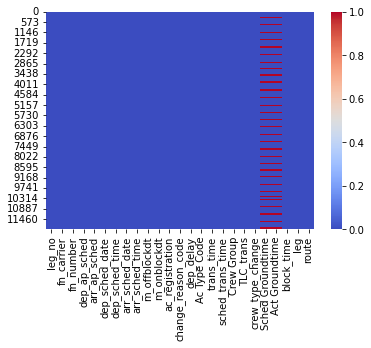

In [7]:
sns.heatmap(flt_info.isnull(), cmap='coolwarm')

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,m_offblock_time,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,route,leg
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2022-04-14 00:40:00,2019-06-01,2022-04-14 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,00:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,East Carmen-North Gregory,North Gregory-East Carmen
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2022-04-14 02:05:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,01:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,East Carmen-Port Bobby,Port Bobby-East Carmen
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2022-04-14 02:20:00,2019-06-01,2022-04-14 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,02:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,East Carmen-Port Ryan,Port Ryan-East Carmen
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2022-04-14 02:25:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,02:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Coleland-East Carmen,Coleland-East Carmen
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2022-04-14 02:30:00,2019-06-01,2022-04-14 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,03:02:00,2019-06-01,DH4,ECLGNX,35.0,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0,East Carmen-East Melissaberg,East Melissaberg-East Carmen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10093,272019792,East Carmen Airlines,EC3244,Youngland,East Carmen,2019-06-30,2022-04-14 17:50:00,2019-06-30,2022-04-14 19:30:00,2019-06-30 17:50:00,2019-06-30 19:45:00,ECLGHX,no reason,0.0,DH4,-31,40,A,"['Cynthia Johnson_300_-31_40_ca', 'Grace Goodm...",[],100.0,102.0,17:50:00,2019-06-30,DH4,ECLGHX,35.0,Youngland,East Carmen,Lake David,2019-06-30 17:50:00,2019-06-30 19:30:00,2019-06-30 21:10:00,2019-06-30 23:05:00,100.0,272019792.0,272003336.0,15.0,NaN,10.0,East Carmen-Youngland,Youngland-East Carmen
10094,271985212,East Carmen Airlines,EC2864,West Ana,East Carmen,2019-06-30,2022-04-14 17:55:00,2019-06-30,2022-04-14 19:40:00,2019-06-30 19:13:00,2019-06-30 21:07:00,ECLGIX,rotational problem,78.0,DH4,17,45,A,"['Monique Soto_264_17_45_ca', 'Ryan Kramer_264...",[],35.0,-31.0,19:13:00,2019-06-30,DH4,ECLGIX,35.0,West Ana,East Carmen,East Melissaberg,2019-06-30 17:55:00,2019-06-30 19:40:00,2019-06-30 20:15:00,2019-06-30 21:50:00,35.0,271985212.0,272205189.0,23.0,NaN,15.0,East Carmen-West Ana,West Ana-East Carmen
10095,272010941,East Carmen Airlines,EC3167,East Carmen,North Anna,2019-06-30,2022-04-14 18:00:00,2019-06-30,

Hypothesis 1: If Sched Groundtime is NA, Act Groundtime is also NA --> True. Act Groundtime also has more NAs than Sched Groundtime. See H3


<AxesSubplot:>

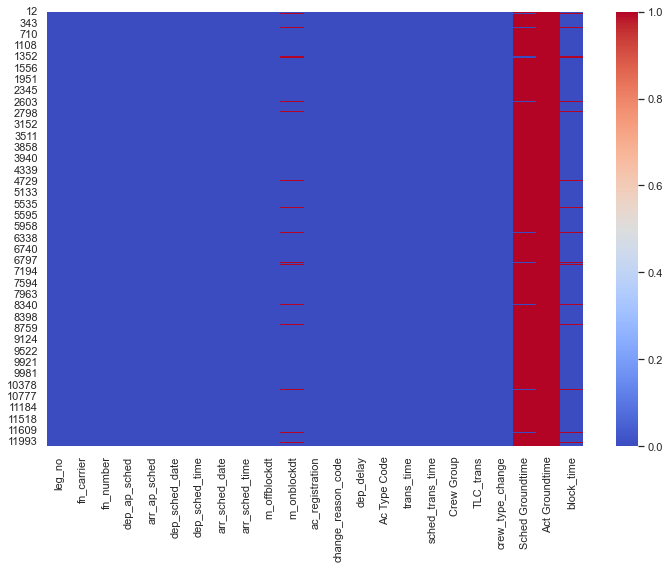

In [174]:
#Hypothesis 1:
flt_info_NA = flt_info[flt_info.isna().any(axis = 1)]
sns.heatmap(flt_info_NA.isnull(), cmap='coolwarm')

In [175]:
flt_info_NA.describe()
# Whenever there is a line with a NA value, Act Groundtime has NA. 

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time
count,2.075000e+03,2075.00000,2075.000000,2075.000000,62.000000,0.0,1992
mean,2.720475e+08,13.17253,27.721928,40.074699,55.403226,NaN,0 days 01:38:49.879518072
std,9.347359e+04,9.38464,32.967727,31.220075,42.031393,NaN,0 days 00:47:25.296097070
min,2.719565e+08,0.00000,-110.000000,0.000000,-115.000000,NaN,0 days 00:28:00
25%,2.719814e+08,3.00000,0.000000,0.000000,45.000000,NaN,0 days 01:08:00
50%,2.720063e+08,15.00000,28.000000,45.000000,45.000000,NaN,0 days 01:29:00
75%,2.721005e+08,19.00000,51.000000,55.000000,53.750000,NaN,0 days 01:55:00
max,2.723603e+08,85.00000,228.000000,330.000000,200.000000,NaN,0 days 05:03:00


Hypothesis 2: Last flight of the day has no value for Sched Groundtime and Act Groundtime

Hypothesis 3: m_onblockdt NAs have values for Sched Groundtime but not for Act Groundtime (to be verified). Those could be cancelled/diverted etc. flts

In [176]:
#Hypothesis 2

<AxesSubplot:>

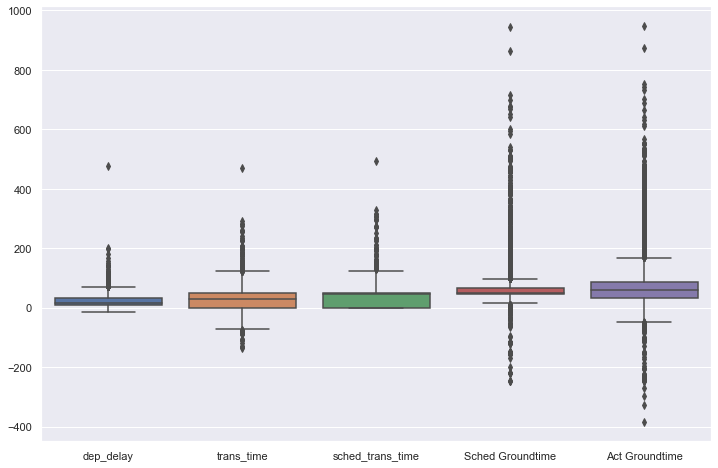

In [177]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))
# Todo: Check NAs for Sched Groundtime and Act Groundtime 
# Todo: Check negative ground time 



Hypothesis 4: Time of day has influence on dep delay

<AxesSubplot:xlabel='dep_sched_time', ylabel='dep_delay'>

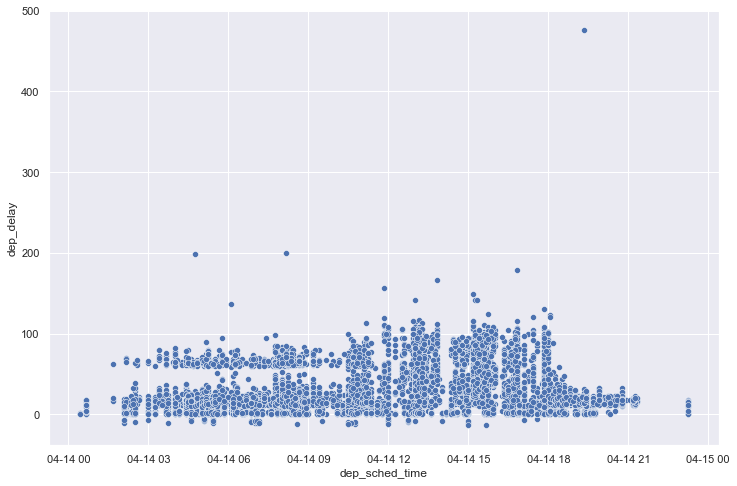

In [178]:
sns.scatterplot(x=flt_info['dep_sched_time'], y=flt_info['dep_delay'])

Questions

! Leg and AC-Type are not sufficient for predictions!

(array([82., 70., 25., 43., 12.,  6., 11.,  6.,  8., 15.,  8.,  8., 24.,
         4.,  4.,  2.,  1.,  8.,  1.,  3.,  3.,  4.,  2.,  3.,  8.,  9.,
         0.,  6.,  2.,  0.,  2.,  6.,  0.,  2.,  2.,  0.,  2.,  6.,  2.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  4.,  2.,  0.,
         4.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  2.,
         0.,  2.]),
 array([  1.    ,   3.2875,   5.575 ,   7.8625,  10.15  ,  12.4375,
         14.725 ,  17.0125,  19.3   ,  21.5875,  23.875 ,  26.1625,
         28.45  ,  30.7375,  33.025 ,  35.3125,  37.6   ,  39.8875,
         42.175 ,  44.4625,  46.75  ,  49.0375,  51.325 ,  53.6125,
         55.9   ,  58.1875,  60.475 ,  62.7625,  65.05  ,  67.3375,
         69.625 ,  71.9125,  74.2   ,  76.4875,  78.775 ,  81.0625,
         83.35  ,  85.6375,  87.925 ,  90.2125,  92.5   ,  94.7875,
         97.075 ,  99.3625, 101.65  , 103.9375, 106.225 , 108.5125

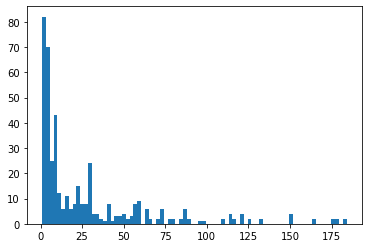

In [8]:
flt_info_solution = flt_info.groupby(['Ac Type Code','leg']).size().reset_index().sort_values(by = [0])
plt.hist(flt_info_solution[0], bins = 80)


TypeError: The DTypes <class 'numpy.dtype[timedelta64]'> and <class 'numpy.dtype[float64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

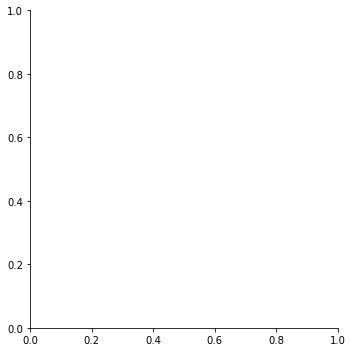

In [10]:
leg_test = flt_info[flt_info["route"] == 'East Carmen-West Jason']
sns.catplot(x=leg_test['leg'], y = leg_test['block_time'], data = leg_test)
#leg_test

In [123]:
flt_info['Ac Type Code'].value_counts()

320    5049
E95    2793
DH4    2256
Name: Ac Type Code, dtype: int64

 ## Ground Info

In [86]:
# Ground Info Dataset
ground_info.head()

,day_of_origin,ac_type,fn_number,ac_registration,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,2019-06-01,DH4,EC3114,ECLGNX,35,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35,272006092,272205857,26,NaN,26.0
1,2019-06-01,320,EC3316,ECLBIX,40,East Latashaview,East Carmen,Juliemouth,2019-06-01 03:15:00,2019-06-01 07:05:00,2019-06-01 07:50:00,2019-06-01 12:05:00,45,272027070,272029306,27,NaN,15.0
2,2019-06-01,321,EC3292,ECLBAX,45,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95,272024970,272022230,27,NaN,25.0
3,2019-06-01,E95,EC3420,ECLWFX,40,East Allisontown,East Carmen,Yoderburgh,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:30:00,2019-06-01 07:05:00,55,272034482,271961698,18,NaN,11.0
4,2019-06-01,DH4,EC3400,ECLGBX,30,Port Courtneytown,East Carmen,West Ana,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:10:00,2019-06-01 07:10:00,35,272033720,271984663,15,NaN,12.0


In [87]:
ground_info.describe()

,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,4173.000000,4173.000000,4.173000e+03,4.173000e+03,4173.000000,3.000000,3769.000000
mean,39.110951,56.080757,2.720592e+08,2.720428e+08,21.959262,21.505556,18.461926
std,3.267831,17.056430,9.876997e+04,9.305571e+04,4.325588,10.667400,11.926491
min,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,40.000000,45.000000,2.719893e+08,2.719841e+08,18.000000,15.400000,13.000000
50%,40.000000,55.000000,2.720152e+08,2.720086e+08,22.000000,16.800000,17.000000
75%,40.000000,65.000000,2.721835e+08,2.720336e+08,26.000000,25.258333,22.000000
max,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000


## Merged Dataset

In [88]:
#Interim: We drop NAs

flt_info = flt_info.dropna()

In [89]:

pd.set_option("display.max_columns", 101)
df = pd.merge(flt_info, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
df.head()



,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,m_offblock_time,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2022-04-14 00:40:00,2019-06-01,2022-04-14 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,00:43:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2022-04-14 02:05:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,01:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2022-04-14 02:20:00,2019-06-01,2022-04-14 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,02:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2022-04-14 02:25:00,2019-06-01,2022-04-14 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,02:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2022-04-14 02:30:00,2019-06-01,2022-04-14 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,03:02:00,2019-06-01,DH4,ECLGNX,35.0,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0


<AxesSubplot:>

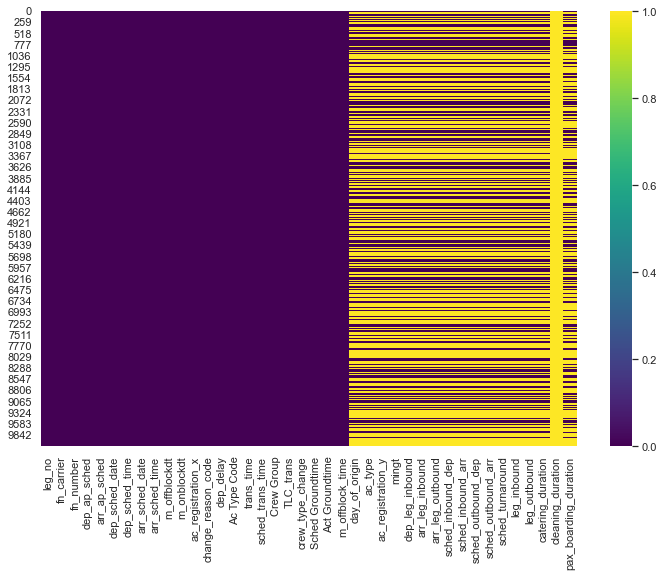

In [90]:
sns.heatmap(df.isna(), cmap = 'viridis' )

In [96]:
df_processed = df
df_processed.to_csv(path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/processed/df_processed.csv')

